In [1]:
import re
import random
import six

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from datautils.vocabulary import Vocabulary
from datautils.serve import DataServer

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

In [ ]:
class constants:
    SNLI_TXT_TRAIN = '/research/data/snli/snli_1.0_train.txt'
    SNLI_TXT_DEV = '/research/data/snli/snli_1.0_dev.txt'
    WORD_START_TOKEN="<START>"
    WORD_END_TOKEN="<END>"

In [21]:
data = pd.read_csv(constants.SNLI_TXT_TRAIN, delimiter='\t',
                           usecols=['gold_label', 'sentence1', 'sentence2'])

In [36]:
data[data.sentence2.apply(lambda s: isinstance(s, str))]

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present
5,contradiction,Children smiling and waving at camera,The kids are frowning
6,contradiction,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.
7,entailment,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.
8,neutral,A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.
9,neutral,An older man sits with his orange juice at a s...,An older man drinks his juice as he waits for ...


In [29]:
[x for x in data.sentence2.values if not isinstance(x, str)]

[nan, nan, nan]

In [39]:
class SNLITextDataset(object):
    """Language pairs text dataset for machine translation
    
       Args:
        data_path (str): Path to language pairs data.
    """

    def __init__(self, data_path):
        data = pd.read_csv(data_path, delimiter='\t',
                           usecols=['gold_label', 'sentence1', 'sentence2'])
        self.data = self.preprocess(data)
        
    def preprocess(self, data):
        lower_case = lambda text: text.lower()
        remove_special = lambda text: re.sub(r'[^A-Za-z0-9.!?#$\n]+', ' ', text)
        move_punctuation = lambda text: re.sub(r"([,.!?])", r" \1 ", text)
        strip = lambda text: text.strip()
        tokenize = lambda text: text.split(" ")
        do_all = lambda text: tokenize(strip(move_punctuation(lower_case(text))))

        data = data[data.sentence2.apply(lambda s: isinstance(s, str))==True]
        data['sentence1'] = data['sentence1'].apply(do_all)
        data['sentence2'] = data['sentence2'].apply(do_all)
        data = data[data['gold_label'] != '-'] # remove sentences with no consensus

        return data
    
    def get_data(self):
        return (self.data['sentence1'].values, 
                self.data['sentence2'].values, 
                self.data['gold_label'])
                

class SNLITokenVectorizer(object):
    def __init__(self, sequence_one_vocab, targets_vocab, max_sequence_length):
        self.sequence_vocab = sequence_one_vocab
        self.targets_vocab = targets_vocab
        self.max_sequence_length = max_sequence_length

    @classmethod
    def induce_from_text(cls, sequence_one_tokens, sequence_two_tokens, targets):
        """
        A TextDataset is converted to a VectorizedDataset created by:
            1. For each variable, mapping the words or characters to an integer
            2. For each variable, packing the integers into a matrix large
                enough to contain the longest sequence for that variable
        :param text_dataset:
        :type text_dataset:
        """
        sequence_vocab = Vocabulary(use_unks=True,
                                    use_start_end=True, 
                                    start_token=constants.WORD_START_TOKEN,
                                    end_token=constants.WORD_END_TOKEN)
        targets_vocab = Vocabulary(use_unks=False,
                                   use_start_end=False)
        sequence_vocab.add_many(token for token_sequence in sequence_one_tokens
                                for token in token_sequence)
        sequence_vocab.add_many(token for token_sequence in sequence_two_tokens
                                for token in token_sequence)
        targets_vocab.add_many(target for target in targets)
        
        max_sequence_one = max(len(token_sequence) for token_sequence in sequence_one_tokens)
        max_sequence_two = max(len(token_sequence) for token_sequence in sequence_two_tokens)
        
        # add two for the start, end tokens
        max_sequence_length = 2 + max(max_sequence_one, max_sequence_two)

        return cls(sequence_vocab, targets_vocab, max_sequence_length)

    def convert_dataset(self, sequence_one_tokens, sequence_two_tokens, targets):
        num_data = len(sequence_one_tokens)

        x_one_seq = np.zeros((num_data, self.max_sequence_length), dtype=np.int64)
        x_two_seq = np.zeros((num_data, self.max_sequence_length), dtype=np.int64)
        y_targets = np.zeros((num_data), dtype=np.int64)

        for seq_i, target in enumerate(targets):
            y_targets[seq_i] = self.targets_vocab[target]

        for seq_i, tokens in enumerate(sequence_one_tokens):
            converted = list(self.sequence_vocab.map(tokens, include_start_end=True))
            x_one_seq[seq_i, :len(converted)] = converted
            
        for seq_i, tokens in enumerate(sequence_two_tokens):
            converted = list(self.sequence_vocab.map(tokens, include_start_end=True))
            x_two_seq[seq_i, :len(converted)] = converted

        return VectorizedIIODataset(x_one_seq, x_two_seq, y_targets)


class VectorizedIIODataset(Dataset):
    def __init__(self, x_input_one, x_input_two, y_target):
        self.x_input_one = x_input_one
        self.x_input_two = x_input_two
        self.y_target = y_target

    def __len__(self):
        return len(self.x_input_one)

    def __getitem__(self, index):
        return {'x_input_one': self.x_input_one[index],
                'x_one_lengths': len(self.x_input_one[index].nonzero()[0]),
                'x_input_two': self.x_input_two[index],
                'x_two_lengths': len(self.x_input_two[index].nonzero()[0]),
                'y_target': self.y_target[index]}


In [40]:
text_dataset = SNLITextDataset(constants.SNLI_TXT_TRAIN)

/home/brian/anaconda3/envs/py3torch/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/brian/anaconda3/envs/py3torch/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
sentences_1, sentences_2, judgements = text_dataset.get_data()
vectorizer = SNLITokenVectorizer.induce_from_text(sentences_1, sentences_2, judgements)
vectorized_dataset = vectorizer.convert_dataset(sentences_1, sentences_2, judgements)

In [43]:
data_server = DataServer(vectorized_dataset)

In [44]:

class SNLIClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, input_vocab_size, output_vocab_size, num_rnn_layers=1):
        super(SNLIClassifier, self).__init__()
        
        self.emb = nn.Embedding(input_vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=num_rnn_layers)
        self.affine = nn.Linear(hidden_dim * 2, output_vocab_size)
        
    def _get_end_vector(self, x_seq, lengths, use_gpu=True):
        if lengths is None:
            return x_seq[:, -1, :]
        elif isinstance(lengths, Variable):
            lengths = lengths.data
        
        last_item_indices = lengths - 1
        if use_gpu:
            last_item_indices += torch.arange(0, x_seq.size(0)).long().cuda() * x_seq.size(1)
            last_item_indices = last_item_indices.cuda()
            x_seq = x_seq.contiguous().cuda()
        else:
            last_item_indices += torch.arange(0, x_seq.size(0)).long() * x_seq.size(1)
            x_seq = x_seq.contiguous()
        
        return x_seq.view(x_seq.size(0) * x_seq.size(1), -1)[last_item_indices]
    
    def forward(self, x_one_in, x_two_in, x_one_lengths=None, x_two_lengths=None, 
                apply_softmax=False, use_gpu=True):
        
        x_one_post_rnn, _ = self.rnn(self.emb(x_one_in))
        x_two_post_rnn, _ = self.rnn(self.emb(x_two_in))
        
        x_one_vector = self._get_end_vector(x_one_post_rnn, x_one_lengths, use_gpu)
        x_two_vector = self._get_end_vector(x_two_post_rnn, x_two_lengths, use_gpu)
        
        x_state_vector = torch.cat([x_one_vector, x_two_vector], 1)
        x_prediction_vector = self.affine(x_state_vector)
        if apply_softmax:
            x_prediction_vector = F.softmax(x_prediction_vector)
        return x_prediction_vector

In [54]:
def accuracy(yhat, ytrue):
        pred = yhat.max(1)[1].type_as(ytrue)
        correct = pred.eq(ytrue)
        if not hasattr(correct, 'mean'):
            correct = correct.cpu()
        return correct.float().mean()

In [45]:
class CrossEntTrainer(object):
    def __init__(self, model, optimizer_class, gpu_mode=False, learning_rate=0.0001):
        self.model = model
        if isinstance(optimizer_class, six.string_types):
            if not hasattr(torch.optim, optimizer_class):
                raise Exception("{} is not a valid optimizer".format(optimizer_class))
            optimizer_class = getattr(torch.optim, optimizer_class)
        self.optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.loss = nn.CrossEntropyLoss()
        self.gpu_mode = gpu_mode
        self.loss_history = []
    
    def _reset_gradient(self):
        self.optimizer.zero_grad()
        self.model.zero_grad()
        
    def train(self, data_server, batch_size=64, num_batches=-1, num_epochs=1):
        if self.gpu_mode:
            self.model.cuda()
            data_server.enable_gpu_mode()
        else:
            self.model.cpu()
            data_server.disable_gpu_mode()
        epoch_bar = tqdm_notebook(total=num_epochs, unit=" epochs", position=0)
        batch_bar = tqdm_notebook(unit=" batches", position=1)
        for _ in range(num_epochs):
            for batch in data_server.serve_batches(batch_size, num_batches):
                self._reset_gradient()
                yhat = self.model(batch['x_input_one'],
                                  batch['x_input_two'],
                                  x_one_lengths=batch['x_one_lengths'],
                                  x_two_lengths=batch['x_two_lengths'],
                                  use_gpu=self.gpu_mode)
                computed_loss = self.loss(yhat, batch['y_target'])
                computed_loss.backward()
                self.optimizer.step()

                computed_loss_ = computed_loss.data.cpu().numpy()[0]
                computed_accuracy = accuracy(yhat, batch['y_target']).data.cpu().numpy()[0]
                
                batch_bar.set_postfix(loss=computed_loss_, accuracy=computed_accuracy)
                self.loss_history.append(computed_loss_)
                batch_bar.update(1)
                
            epoch_bar.update(1)

        batch_bar.clear()

In [49]:
model_parameters = dict(embedding_dim=64, 
                        hidden_dim=32,
                        num_rnn_layers=1)
model = SNLIClassifier(input_vocab_size=len(vectorizer.sequence_vocab),
                        output_vocab_size=len(vectorizer.targets_vocab), **model_parameters)
data_server = DataServer(vectorized_dataset)

In [50]:
trainer = CrossEntTrainer(model, "Adam", True)

In [51]:
try:
    trainer.train(data_server, num_epochs=400, batch_size=256)
except KeyboardInterrupt:
    pass

In [52]:
sns.set_context("poster")
sns.set_style("whitegrid")

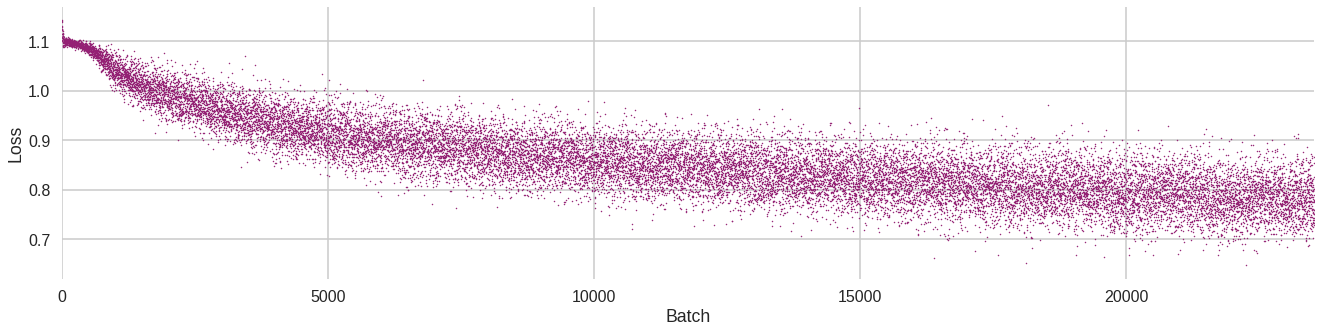

In [53]:
plt.figure(figsize=(20,5))
plt.scatter(np.arange(len(trainer.loss_history)), trainer.loss_history, color='#942174', s=1);
plt.xlim(0,len(trainer.loss_history));
plt.xlabel("Batch")
plt.ylabel("Loss");
sns.despine(left=True,bottom=True)